# Assignment 2 CS 419: Support Vector Machines with Kernel Methods for Credit Card Fraud Detection

**Student 1 Name**: Vedika Doke\
**Student 1 Roll**: 24B1231\
**Student 2 Name**: Aditya Khambete\
**Student 2 Roll**: 23B3315

---
This notebook is a self-contained submission for Assignment 1 Group T. It includes both the implementation and the wiki article. All cells can be run sequentially to view the results.

## Part 1: Code Implementation

This section contains the full Python implementation of our machine learning pipeline for credit card fraud detection. We will proceed through the following key stages:

1.  **Setup:** Importing all necessary libraries for data manipulation, machine learning, and visualization.
2.  **Data Preprocessing:** Loading the dataset, scaling critical features like `Time` and `Amount`, and performing a stratified split to create training, validation, and test sets.
3.  **Handling Class Imbalance:** Applying the SMOTE (Synthetic Minority Over-sampling Technique) to the training data to create a balanced dataset for model training.
4.  **Model Training & Comparison:** Implementing and training several classifiers: Perceptron, Logistic Regression, and Support Vector Machines with three distinct kernels (**linear, polynomial, and RBF**).
5.  **Evaluation:** Analyzing the performance of each model on the untouched test set using appropriate metrics for imbalanced data, such as the Precision-Recall AUC, and visualizing the results.

### Step 1: Setup
Importing all necessary libraries for data manipulation, machine learning, and visualization.

In [1]:
# Data and Math
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Scikit-learn for ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    precision_recall_curve,
    auc,
    confusion_matrix
)

# Imbalanced-learn for SMOTE
from imblearn.over_sampling import SMOTE

print("Libraries imported successfully!")

Libraries imported successfully!


### Step 2: Data Preprocessing
Loading the dataset of Kaggle from the public URL. Critical preprocessing steps are scaling the Time and Amount columns and then performing a stratified split of the data. Stratification ensures the rare fraud cases are distributed proportionally across our training, validation, and test sets.

In [2]:
# Public url for the dataset
url = 'https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv'

# Loading the dataset from the URL
df = pd.read_csv(url)
print('Dataset loaded successfully from URL.')
print(f"Dataset shape: {df.shape}")
print(f"Fraudulent transactions: {df['Class'].value_counts()[1]} ({df['Class'].value_counts()[1]/len(df)*100:.2f}%)")

# Feature Scaling
scaler = StandardScaler()
df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))
df.drop(['Time', 'Amount'], axis=1, inplace=True)
print("\n'Time' and 'Amount' features scaled and replaced.")

# Data Splitting (Stratified)

# Define features (X) and target (y)
X = df.drop('Class', axis=1)
y = df['Class']

# First split: 60% train, 40% temp (for validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

# Second split: 50% of temp for validation, 50% for test (20% of original each)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("\nData splitting complete:")
print(f"Training set shape:   {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape:       {X_test.shape}")

Dataset loaded successfully from URL.
Dataset shape: (284807, 31)
Fraudulent transactions: 492 (0.17%)

'Time' and 'Amount' features scaled and replaced.

Data splitting complete:
Training set shape:   (170884, 30)
Validation set shape: (56961, 30)
Test set shape:       (56962, 30)


### Step 3: Handling Class imbalance with SMOTE
To address the extreme class imbalance in our dataset, we apply SMOTE to the **training data** only. This is used to generate synthetic fraud examples to create a balanced dataset for the models to learn from without causing data leakage into our validation or test sets.

In [3]:
print(f"Original training set class distribution:\n{y_train.value_counts()}")

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

print("\n After applying SMOTE: ")
print(f"Resampled training set class distribution:\n{y_smote.value_counts()}")

Original training set class distribution:
Class
0    170589
1       295
Name: count, dtype: int64

 After applying SMOTE: 
Resampled training set class distribution:
Class
0    170589
1    170589
Name: count, dtype: int64


### Step 4: Initial Model Training and Comparison
Now we shall train our baseline models. This includes Perceptron, Logistic Regression, and SVM with all three required kernels. The `class_weight='balanced'` is used as a second technique to handle imbalance by assigning a **higher penalty for misclassifying fraud cases**. (All models are trained on the SMOTE-balanced data and evaluated on the untouched test set)

In [4]:
# Create a smaller subset for faster training
subset_size = 40000  # Adjust as needed (e.g., 10000 for even faster testing)
if len(X_smote) > subset_size:
    X_smote_subset, _, y_smote_subset, _ = train_test_split(
        X_smote, y_smote, train_size=subset_size, random_state=42, stratify=y_smote
    )
else:
    X_smote_subset, y_smote_subset = X_smote, y_smote

print(f"Training will be performed on a faster subset of {len(X_smote_subset)} samples.")

models = {
    "Perceptron": Perceptron(class_weight='balanced', random_state=42, max_iter=1000, tol=1e-3),
    "Logistic Regression": LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear'),
    "SVM (Linear)": SVC(kernel='linear', class_weight='balanced', probability=False, random_state=42),  # Set to False for speed
    "SVM (Polynomial)": SVC(kernel='poly', degree=3, class_weight='balanced', probability=False, random_state=42),
    "SVM (RBF)": SVC(kernel='rbf', class_weight='balanced', probability=False, random_state=42)
}

results = {}

for name, model in models.items():
    print(f" Training {name} ")
    model.fit(X_smote_subset, y_smote_subset)
    y_pred = model.predict(X_test)

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_proba = model.decision_function(X_test)  # Fallback for PR-AUC without probabilities
    else:
        y_proba = y_pred  # Rare fallback

    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)

    results[name] = {
        "Precision (Fraud)": report['1']['precision'],
        "Recall (Fraud)": report['1']['recall'],
        "F1-Score (Fraud)": report['1']['f1-score'],
        "PR-AUC": pr_auc
    }

results_df = pd.DataFrame(results).T
print("\n Initial Model Comparison ")
print(results_df)

Training will be performed on a faster subset of 40000 samples.
 Training Perceptron 
 Training Logistic Regression 
 Training SVM (Linear) 
 Training SVM (Polynomial) 
 Training SVM (RBF) 

 Initial Model Comparison 
                     Precision (Fraud)  Recall (Fraud)  F1-Score (Fraud)  \
Perceptron                    0.029490        0.898990          0.057106   
Logistic Regression           0.059563        0.909091          0.111801   
SVM (Linear)                  0.054315        0.909091          0.102506   
SVM (Polynomial)              0.534161        0.868687          0.661538   
SVM (RBF)                     0.081502        0.898990          0.149454   

                       PR-AUC  
Perceptron           0.758648  
Logistic Regression  0.796558  
SVM (Linear)         0.766354  
SVM (Polynomial)     0.705343  
SVM (RBF)            0.667233  


### Step 5: Evaluation and Visualization
The Precision-Recall (PR) curve is the most informative visualization for imbalanced classification. A model is superior if its curve is closer to the top-right corner (high precision and high recall).

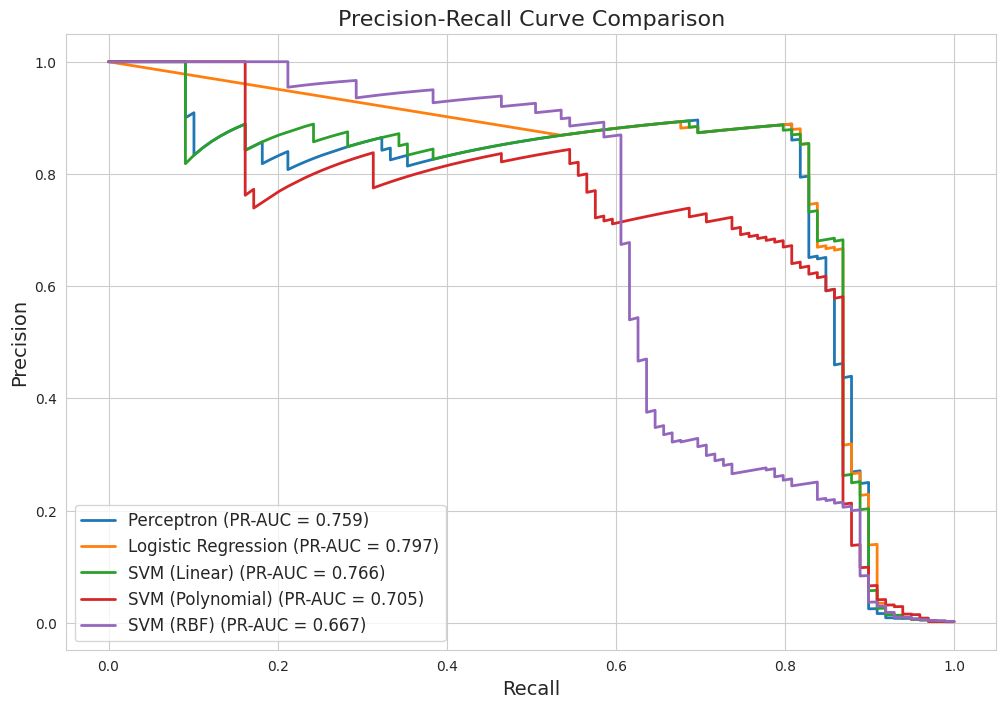

In [5]:
plt.figure(figsize=(12, 8))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.decision_function(X_test)

    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = results[name]["PR-AUC"]

    plt.plot(recall, precision, lw=2, label=f'{name} (PR-AUC = {pr_auc:.3f})')

plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curve Comparison', fontsize=16)
plt.legend(loc='lower left', fontsize=12)
plt.grid(True)
plt.show()

### Step 6: Hyperparameter Tuning (RBF SVM)
Instead of a broad `GridSearchCV` (which is computationally expensive), we will manually test a few well-regarded parameter combinations for the RBF SVM. We will train on a subset of the SMOTE data and evaluate against the **untouched validation set** to select the best model.

In [8]:
import time

# Define parameter combinations for manual testing
param_combinations = [
    {'C': 1.0, 'gamma': 0.001, 'name': 'Conservative'},
    {'C': 10.0, 'gamma': 0.001, 'name': 'Balanced'},
    {'C': 10.0, 'gamma': 0.0001, 'name': 'Broad Influence'},
    {'C': 100.0, 'gamma': 0.0001, 'name': 'Strong Regularization'},
]

print("Starting manual hyperparameter testing for RBF SVM...\n")

best_val_score = 0
best_params = None
best_model = None

# Use the 40k subset defined in Step 4 for this initial tuning
# (X_smote_subset, y_smote_subset)

for params in param_combinations:
    print(f"Testing {params['name']}: C={params['C']}, gamma={params['gamma']}")

    model = SVC(
        kernel='rbf',
        C=params['C'],
        gamma=params['gamma'],
        class_weight='balanced',
        probability=False,
        random_state=42
    )

    # Train on the SMOTE subset
    print("   Training on subset...")
    model.fit(X_smote_subset, y_smote_subset)

    # Evaluate on the original, imbalanced validation set
    y_val_scores = model.decision_function(X_val)
    precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_scores)
    pr_auc_val = auc(recall_val, precision_val)

    print(f"   Validation PR-AUC: {pr_auc_val:.4f}\n")

    if pr_auc_val > best_val_score:
        best_val_score = pr_auc_val
        best_params = params
        best_model = model

print("-" * 70)
print("Best parameters selected based on validation set:")
print(f"   Configuration: {best_params['name']}")
print(f"   C = {best_params['C']}")
print(f"   gamma = {best_params['gamma']}")
print(f"   Validation PR-AUC: {best_val_score:.4f}")
print("-" * 70)

# --- Training the Final Model ---
# Now, train the best model on a larger subset of the SMOTE data

print("\nTraining final model on a larger dataset (80k samples)...")
larger_size = 80000
if len(X_smote) > larger_size:
    X_large, _, y_large, _ = train_test_split(
        X_smote, y_smote, train_size=larger_size, random_state=42, stratify=y_smote
    )
else:
    X_large, y_large = X_smote, y_smote

final_model = SVC(
    kernel='rbf',
    C=best_params['C'],
    gamma=best_params['gamma'],
    class_weight='balanced',
    probability=False, # Still False for decision_function
    random_state=42
)

start = time.time()
final_model.fit(X_large, y_large)
elapsed = time.time() - start
print(f"Final model training complete in {elapsed:.1f} seconds.\n")

# --- Final Evaluation on Test Set ---
print("Evaluating final tuned model on the test set:")
y_pred_tuned = final_model.predict(X_test)
y_scores_tuned = final_model.decision_function(X_test)

print("\nClassification Report (Tuned Model):")
print(classification_report(y_test, y_pred_tuned, zero_division=0))

# Calculate PR-AUC for the tuned model
precision_tuned, recall_tuned, _ = precision_recall_curve(y_test, y_scores_tuned)
pr_auc_tuned = auc(recall_tuned, precision_tuned)

# Compare to baseline
initial_rbf_auc = results['SVM (RBF)']['PR-AUC']
improvement = pr_auc_tuned - initial_rbf_auc

print("-" * 70)
print("Final Model Performance:")
print(f"   Tuned RBF PR-AUC:   {pr_auc_tuned:.4f}")
print(f"   Baseline RBF PR-AUC: {initial_rbf_auc:.4f}")
print(f"   Improvement:        {improvement:+.4f} ({improvement/initial_rbf_auc*100:+.1f}%)")
print("-" * 70)

Starting manual hyperparameter testing for RBF SVM...

Testing Conservative: C=1.0, gamma=0.001
   Training on subset...
   Validation PR-AUC: 0.5778

Testing Balanced: C=10.0, gamma=0.001
   Training on subset...
   Validation PR-AUC: 0.6084

Testing Broad Influence: C=10.0, gamma=0.0001
   Training on subset...
   Validation PR-AUC: 0.6636

Testing Strong Regularization: C=100.0, gamma=0.0001
   Training on subset...
   Validation PR-AUC: 0.6878

----------------------------------------------------------------------
Best parameters selected based on validation set:
   Configuration: Strong Regularization
   C = 100.0
   gamma = 0.0001
   Validation PR-AUC: 0.6878
----------------------------------------------------------------------

Training final model on a larger dataset (80k samples)...
Final model training complete in 81.2 seconds.

Evaluating final tuned model on the test set:

Classification Report (Tuned Model):
              precision    recall  f1-score   support

         

### Step 7: Final Visualization
Finally, we plot the PR curve of our new tuned model against the original baseline models to visually confirm the impact of hyperparameter tuning.

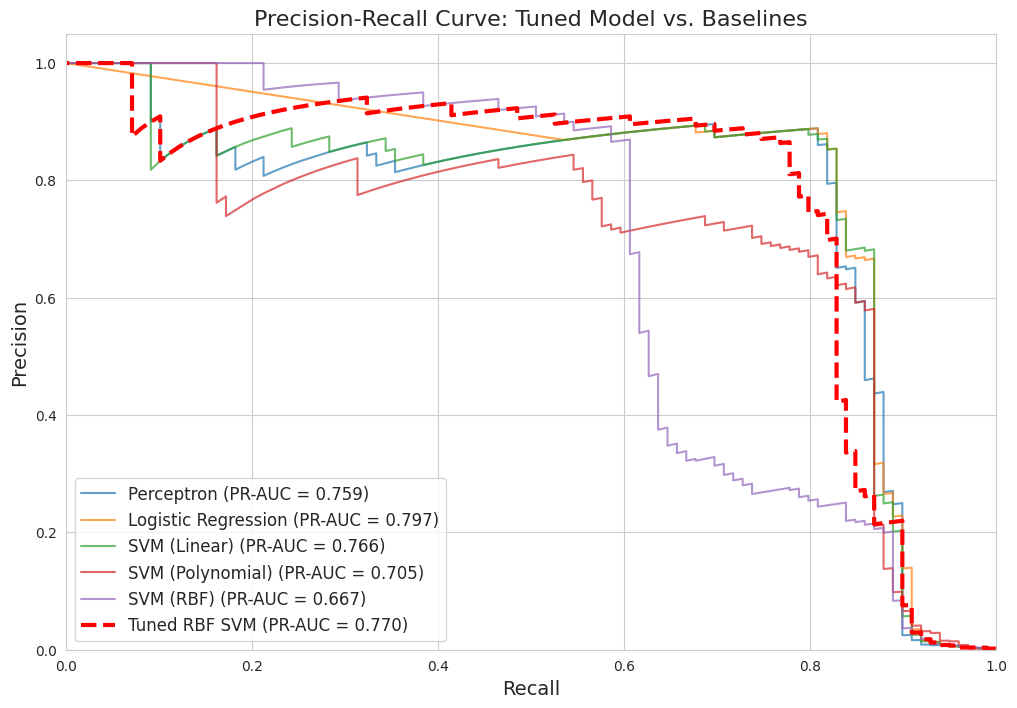

In [9]:
plt.figure(figsize=(12, 8))

# Plot initial models from Step 4
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.decision_function(X_test)

    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = results[name]["PR-AUC"]

    plt.plot(recall, precision, lw=1.5, alpha=0.7,
             label=f'{name} (PR-AUC = {pr_auc:.3f})')

# Plot the new Tuned RBF SVM
plt.plot(recall_tuned, precision_tuned, lw=3,
         label=f'Tuned RBF SVM (PR-AUC = {pr_auc_tuned:.3f})',
         linestyle='--', color='red')

plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curve: Tuned Model vs. Baselines', fontsize=16)
plt.legend(loc='lower left', fontsize=12)
plt.grid(True)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

## Part 2: The Wiki Article
This section presents the assignment's findings in the format of an encyclopedic wiki article.

# **Support Vector Machines with Kernel Methods for Credit Card Fraud Detection**

## **1. Overview**

Detecting fraudulent credit card transactions means identifying the tiny fraction of transactions that are unauthorized (typically 0.1%–1% of transactions) among vast number of legitimate ones. This is a high-stakes classification task: missed fraud (false negatives) produces direct financial loss; excessive false alarms (false positives) damage customer experience.

This task is a machine learning challenge due to several factors:

* **Extreme Class Imbalance**: Fraudulent transactions are exceptionally rare, often being less than 0.1% of total transaction volume. This small fraction makes it difficult for standard algorithms to learn the defining features of fraud.
* **High Cost of Errors**:
    * **False Negatives** (missed fraud) result in direct financial losses and loss of customer trust.
    * **False Positives** (legitimate transactions flagged as fraud) create significant customer frustration.
* **Adversarial and Dynamic Nature**: Fraudsters continuously adapt their methods, requiring detection models to be robust and evolve over time.

**Support Vector Machines (SVMs)** offer a solution uniquely suited to these challenges. By moving beyond the limitations of simple linear models like the Perceptron, SVMs provide:
1.  **Optimal Margin Maximization**: For better generalization on unseen data.
2.  **Weighted Penalties**: To counteract class imbalance by focusing on the minority (fraud) class.
3.  **The Kernel Trick**: To model complex, non-linear relationships in transaction data, which are characteristic of complex fraud patterns.

Effective implementation of SVMs can save financial institutions a lot of money annually, secure customer accounts, and ensure the integrity of the digital payments system.

---

## **2. Methodology: Core SVM Concepts for Fraud Detection**

### **The Optimal Margin Hyperplane**

Unlike a Perceptron, which finds *any* separating hyperplane **[Lec 6; slide 23]**, an SVM is designed to find the **optimal margin hyperplane**. This is the decision boundary that maximizes the distance to the nearest data points of both classes. This distance is called the **margin**.

* A wider margin signifies a more confident classifier. It acts as a buffer, making the model less sensitive to noise and improving its ability to correctly classify new, unseen transactions.

### **Support Vectors**

The data points that lie on the margin are called **support vectors**. These are the most critical examples in the dataset because they alone define the position of the optimal hyperplane. In the context of fraud, support vectors represent the most ambiguous transactions, basically the edge cases that are most difficult to distinguish between legitimate and fraudulent.(borderline fraud/legitimate)

### **Mathematical Formulation**

The core of SVM is an optimization problem to find the weight vector `w` and bias `b` that define the hyperplane:

* **Objective**: Minimize `0.5 * ||w||²` (which is equivalent to maximizing the margin `2/||w||` , larger margins usually indicate better generalization)

* **Constraint**: `yᵢ(wᵀxᵢ + b) ≥ 1` for each transaction `xᵢ` with label `yᵢ` (+1 for fraud, -1 for legitimate).

The classification of a new transaction `x` is determined by the **decision function**: `f(x) = sign(wᵀx + b)`.

---

## **3. The Kernel Trick for Non-linear Fraud Patterns**

Fraudulent behavior is rarely simple enough to be separated by a straight line. Patterns often involve complex, **non-linear** interactions between features like transaction amount, time of day, merchant category, and location.

The **kernel trick** is SVM's solution to this problem. It allows the algorithm to learn a non-linear decision boundary by implicitly mapping the data into a higher-dimensional space where it *is* linearly separable. This is achieved without the immense computational cost of actually transforming the data.
**[Lecture 8; Slide 60]**

### **Key Kernel Functions for Implementation**

1.  **Linear Kernel**: `K(xᵢ, xⱼ) = xᵢᵀxⱼ`
    * **Use Case**: A simple Kernel. Appropriate when a linear separation is believed to be sufficient.
2.  **Polynomial Kernel**: `K(xᵢ, xⱼ) = (γxᵢᵀxⱼ + r)ᵈ`
    * **Use Case**: Captures interactions between features up to a degree `d`. Useful for modeling more complex, curved decision boundaries.
3.  **Radial Basis Function (RBF) Kernel**: `K(xᵢ, xⱼ) = exp(-γ||xᵢ - xⱼ||²)`    **[Lecture 8; Slide 42]**
    * **Use Case**: A powerful kernel. It can model complex patterns by considering the local influence of support vectors.

---

## **4. Hyperparameter Tuning using a Validation Set**

The performance of an SVM is highly dependent on the choice of its hyperparameters.

* **`C` (Regularization Parameter)**: Controls the trade-off between maximizing the margin and minimizing classification errors on the training data.
    * A **low `C`** creates a wider margin, allowing some misclassifications to achieve better generalization.
    * A **high `C`** forces the model to classify training points correctly, leading to a narrower margin and a  of **overfitting**.
* **`gamma` (Kernel Coefficient)**: For RBF and Polynomial kernels, `gamma` defines the influence of a single training example.
    * A **low `gamma`** results in a smoother, more generalized decision boundary.
    * A **high `gamma`** leads to a highly complex boundary that closely fits the training data, risking overfitting.

To find the optimal combination of C and gamma, we test several promising parameter sets. Each set is used to train a model on our balanced training data, which is then evaluated against the held-out validation set. The parameter combination that yields the highest PR-AUC score on the validation set is selected as the optimal choice for the final model.

---

## **5. Handling Extreme Class Imbalance in Fraud Detection**

When fraud cases are less than 1% of the data, a standard SVM will achieve high accuracy by simply classifying all transactions as legitimate. To build a useful model, we must employ techniques to address this great imbalance.

1.  **Weighted SVM (Cost-Sensitive Learning)**
    * **Method**: Assign a much higher penalty for misclassifying the minority (fraud) class. This is achieved in scikit-learn by setting `class_weight='balanced'`. The algorithm then adjusts the `C` parameter for each class to be inversely proportional to its frequency, forcing the model to pay close attention to fraud examples.
2.  **SMOTE (Synthetic Minority Over-sampling Technique)**
    * **Method**: Generate new, synthetic fraud examples in the training data. SMOTE works by selecting a fraud instance, identifying its nearest neighbors that are also fraud cases, and creating a new synthetic point along the line segments connecting them. This provides the model with more fraud-like examples to learn from.
    * **A Crucial Implementation Detail**: SMOTE must **only be applied to the training set** *after* splitting the data. Applying it before the split causes data leakage, leading to an artificially inflated and unreliable performance evaluation.

These two methods can also be combined. In this project's implementation, we first apply SMOTE to the training set and then set `class_weight='balanced'` in the SVM. This 'double-dip' approach forces an exceptionally aggressive focus on the minority (fraud) class, which can be an effective strategy to maximize recall.

---

## **6. Dataset, Feature Engineering, and Preprocessing**

### **Dataset Structure**

The standard credit card fraud dataset retrieved from **Kaggle** includes:
* **`Time`** and **`Amount`**: The primary non-anonymized features.
* **`V1-V28`**: Anonymized features derived from a Principal Component Analysis (PCA) transformation to protect user privacy.
* **`Class`**: The binary target variable (0 = legitimate, 1 = fraud).

### **Feature Engineering and Scaling**

* **Feature Scaling**: This is a **mandatory** preprocessing step for SVMs. Because the algorithm is based on calculating distances to define the margin, features must be on a similar scale. We use `StandardScaler` to transform all features to have zero mean and unit variance.

### **Data Splitting**

A **stratified split** is used to ensure the percentage of fraud cases is identical across the training, validation, and test sets. A typical strategy is a **60-20-20** split.

---

## **7. Robustness Testing with Transaction Noise**

Real-world data is imperfect. It may include :
* Duplicate Transactions: The same transaction is recorded multiple times due to system retries,etc. For example, A customer’s card is swiped twice at the same merchant, but only one charge is legitimate while both are logged.
* Mislabeled Transactions: Transactions are sometimes incorrectly labeled as fraud or legitimate because of delayed confirmation, investigation errors,etc.

To simulate this, we can test our model's robustness by injecting synthetic noise into the training data:
* **Label Noise**: Randomly flipping a small percentage of labels (fraud ↔ legitimate).
* **Feature Noise**: Adding small-magnitude Gaussian noise to the numerical features.

**Hypothesis**: The SVM's principle of maximizing the margin provides an inherent buffer against such noise. We expect the SVM to demonstrate less performance degradation on a clean test set compared to Logistic Regression or a Perceptron when trained on noisy data.

---

## **8. Multilingual Data Handling for Global Fraud Detection**

For a multinational institution, transaction data (e.g., merchant names) can appear in many languages. An SVM cannot process this raw text.

**Solution Pipeline**:
1.  **Language Detection**: Identify the language of the text feature.
2.  **Multilingual Embeddings**: Use a transformer model like **XLM-RoBERTa**. These models convert text from any supported language into a fixed-size numerical vector that captures its semantic meaning. For example, "Restaurant" and "Restaurante" will be mapped to very similar vectors.
3.  **Feature Concatenation**: Combine these powerful text-based vectors with the existing numerical transaction features.
4.  **Train SVM**: Train the SVM on the enriched, combined feature space to leverage textual information for more accurate fraud detection.

**The dataset in this project can be viewed as the result of such a process, where all original features, including any potential text data has been vectorized and anonymized via PCA into a numerical embedding suitable for a machine learning model.**

---

## **9. Evaluation Metrics for Fraud Detection**

**Accuracy is a misleading and inappropriate metric** for this problem. Instead, we must use metrics that evaluate the model's ability to identify the rare fraud class:      
**[Lecture 13; Slide 7]**

* **Precision**: `TP / (TP + FP)`
    * Of the transactions we flagged as fraud, what fraction were actually fraudulent?
    * *Goal* : High precision minimizes false alarms and customer friction.
* **Recall (Sensitivity)**: `TP / (TP + FN)`
    * Of all the fraudulent transactions that occurred, what fraction did we successfully catch?
    * *Goal* : High recall minimizes financial losses from missed fraud.
* **F1-Score**: `2 * (Precision * Recall) / (Precision + Recall)`
    * The harmonic mean of precision and recall, providing a single, balanced measure of performance.
* **ROC Curve**:
    * Plots the True Positive Rate (TPR or Recall) against the False Positive Rate (FPR) at various decision thresholds.
* **Precision-Recall AUC (PR-AUC)**:
    * The area under the Precision-Recall curve. This is the **most important summary metric** for highly imbalanced datasets, as it evaluates the trade-offs between precision and recall across all possible thresholds.

---

## **10. Model Comparison and Analysis**

To demonstrate the superiority of the SVM, a comparative analysis should be performed against:
1.  **Perceptron**
2.  **Logistic Regression**
3.  **SVM (with Linear, Polynomial, and RBF kernels)**

A final comparison table summarizing the **Precision, Recall, F1-Score, and PR-AUC** for all models on the held-out test set is essential.

**Precision-Recall Curves** are more informative than ROC curves for imbalanced tasks. They visually represent the trade-off between flagging transactions correctly (precision) and catching all possible frauds (recall). The choice of an "operating point" on this curve depends on business strategy: a bank may prioritize high recall to prevent financial loss, while a different business may prioritize high precision to maintain a frictionless customer experience.

---

## **11. Theoretical Insights: Connection to Perceptron**

The Perceptron convergence theorem guarantees that the algorithm will find a separating hyperplane in a finite number of steps *if the data is linearly separable*. The number of mistakes is bounded by `1/γ²`, where `γ` is the margin.

The SVM provides a significant theoretical advantage: it **explicitly finds the hyperplane that maximizes `γ`**. By maximizing the margin, the SVM finds the most robust and generalizable solution, theoretically minimizing the mistake bound. Furthermore, through the **kernel trick** and **soft-margin classification** (via the `C` parameter), the SVM framework elegantly handles data that is non-linearly separable or noisy, conditions under which the standard Perceptron algorithm would fail to converge.

---

## **12. FinTech Applications and Business Impact**

The primary application is **real-time transaction fraud detection**. However, the same SVM methodologies are highly effective in other FinTech domains:

* **Account Takeover and Money Laundering Detection**
* **Credit Card Application and Insurance Fraud**

The business impact is measured through key performance indicators (KPIs):
* **Fraud Prevented**: Quantified by `Recall × Average Fraud Amount`.
* **Operational Costs**: Reduction in investigation costs due to higher `Precision`.
* **Customer Satisfaction**: Improved trust and lower churn from a low false-positive rate.
* **Regulatory Compliance**: Adherence to standards like PCI-DSS.

**Deployment considerations** include establishing a pipeline for frequent model retraining, A/B testing new models before full rollout, and continuous production monitoring to combat evolving fraud tactics.


### **Citations and References**
1. CS 419 Slides, Autumn 2025, Prof. Ganesh Ramakrishnan
2. Dataset: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud